In [103]:
import pandas as pd
import numpy as np
import requests
import bs4
import matplotlib.pyplot as plt
import pickle
import time
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# 1. Сбор данных
## 1.1 Получение страниц яндекс-маркета с отзывами о телефонах
Работает как минимум 20 000 секунд = 5.55 часов. Можно попробовать сократить время сна или просто оставить на ночь.

In [104]:
# Чтобы Яндекс-маркет не заподозрил в нас робота и не отправил на страницу с капчей, отправим в хедере User-Agent и 
# Cookie (можно взять из реального запроса на яндекс-маркет в браузере в режиме просмотра кода в разделе Network)
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                         'AppleWebKit/537.36 (KHTML, like Gecko) '
                         'Chrome/80.0.3987.122 Safari/537.36',
           'Cookie': 'here put your cookie'}

# Ссылки были получены и распаршены автоматически со страницы https://market.yandex.ru/catalog--mobilnye-telefony/54726/list?text=%D1%82%D0%B5%D0%BB%D0%B5%D1%84%D0%BE%D0%BD&hid=91491&rs=eJwzYgpgBAABcwCG&local-offers-first=0&how=opinions
hrefs = ['/product--smartfon-samsung-galaxy-s-ihttps://market.yandex.ru/catalog--mobilnye-telefony/54726/list?hid=91491&text=%D1%82%D0%B5%D0%BB%D0%B5%D1%84%D0%BE%D0%BD&glfilter=4925738%3A1&onstock=0&local-offers-first=0ii-gt-i9300-16gb/8226067/reviews',
         '/product--telefon-nokia-5130-xpressmusic/3566046/reviews',
         '/product--telefon-nokia-6300/987723/reviews',
         '/product--smartfon-xiaomi-redmi-4-prime/1713398799/reviews',
         '/product--telefon-nokia-5310-xpressmusic/1557254/reviews',
         '/product--smartfon-xiaomi-redmi-4x-32gb/1720465387/reviews',
         '/product--smartfon-samsung-galaxy-s4-gt-i9500-16gb/9323459/reviews',
         '/product--telefon-nokia-x2-00/6175532/reviews',
         '/product--smartfon-apple-iphone-5-16gb/8454852/reviews',
         '/product--smartfon-samsung-galaxy-s7-32gb/13485515/reviews',
         '/product--smartfon-samsung-galaxy-a50-64gb/394273081/reviews',
         '/product--smartfon-nokia-c5-00/6097484/reviews',
         '/product--smartfon-samsung-galaxy-j1-2016-sm-j120f-ds/13340782/reviews',
         '/product--smartfon-samsung-galaxy-s8/1722193751/reviews',
         '/product--telefon-samsung-s5620/6058600/reviews',
         '/product--smartfon-nokia-lumia-800/7752795/reviews',
         '/product--smartfon-asus-zenfone-2-ze551ml-4-32gb/12568545/reviews',
         '/product--telefon-nokia-c3/6152258/reviews',
         '/product--smartfon-asus-zenfone-5-a501cg-16gb/10988849/reviews',
         '/product--smartfon-asus-zenfone-2-laser-ze500kl-16gb/12772728/reviews',
         '/product--smartfon-xiaomi-redmi-3s-16gb/13953515/reviews',
         '/product--telefon-sony-ericsson-w580i/1012211/reviews',
         '/product--smartfon-nokia-c7-00/6413578/reviews',
         '/product--smartfon-samsung-galaxy-s7-edge-32gb/13485518/reviews',
         '/product--smartfon-xiaomi-redmi-note-5-4-64gb/1968186709/reviews',
         '/product--smartfon-apple-iphone-se-32gb/1721921261/reviews',
         '/product--smartfon-samsung-galaxy-s5-sm-g900f-16gb/10725078/reviews',
         '/product--smartfon-xiaomi-redmi-5-plus-4-64gb/1831859946/reviews',
         '/product--smartfon-xiaomi-mi-a1-64gb-android-one/1732136246/reviews',
         '/product--smartfon-xiaomi-redmi-note-7-4-64gb/368058325/reviews',
         '/product--smartfon-xiaomi-mi-max-2-64gb/1727124138/reviews',
         '/product--smartfon-xiaomi-redmi-4x-16gb/1720328396/reviews',
         '/product--telefon-nokia-1280/6258760/reviews',
         '/product--smartfon-sony-xperia-j/8440056/reviews',
         '/product--smartfon-honor-10-4-64gb/43052347/reviews',
         '/product--telefon-sony-ericsson-s500i/1023213/reviews',
         '/product--smartfon-yandex-telefon/177547282/reviews',
         '/product--smartfon-lg-g4-h818/12466715/reviews',
         '/product--telefon-nokia-x1-01/7307224/reviews',
         '/product--telefon-sony-ericsson-k770i/1044411/reviews',
         '/product--smartfon-honor-9-lite-32gb/1901396991/reviews',
         '/product--smartfon-xiaomi-redmi-4a-16gb/1713398800/reviews', 
         '/product--smartfon-lenovo-p780-8gb/10546687/reviews', 
         '/product--telefon-nokia-x3-02/6374952/reviews', 
         '/product--telefon-sony-ericsson-k750i/631849/reviews', 
         '/product--smartfon-honor-8x-4-64gb/199806155/reviews', 
         '/product--telefon-samsung-c3322/7275269/reviews', 
         '/product--telefon-sony-ericsson-t700/2470025/reviews']

# Количества отзывов были также получены как указано выше. Нужны для расчета количества страниц с отзывами из расчета 
# по 10 отзывов на страницу
reviews_number = [931, 756, 743, 688, 645, 562, 528, 505, 487, 485, 473, 454, 450, 449, 439, 435, 433, 418, 417, 403, 
                  373, 369, 360, 359, 349, 345, 345, 339, 333, 329, 328, 326, 325, 316, 314, 312, 300, 297, 288, 284, 
                  281, 280, 279, 278, 274, 263, 262, 259]

# Записываем логи в файл log, чтобы знать, в какой момент оборвалось соединение
with open('log', 'a') as log_file:
    try:
        errors = []
        file_name_counter = 2000 # имя первого файла респонса
        s = requests.Session() #сессия, чтобы сохранялись куки
        s.headers.update(headers)
        log_file.write('Session has been opened \n')
        log_file.flush()
        
        # итерируемся по страницам с отзывами на разные телефоны, указанные выше
        for i in range(1, len(hrefs)):
            url = 'https://market.yandex.ru' + hrefs[i]
            n = reviews_number[i]
            number_of_pages = n // 10 + 1 #расчитываем количество сраниц
            log_file.write('Start working with ' + str(i) + ' ' + url + '\n')
            log_file.flush()
            
            # Итерируемся по всем страницам с отзывами
            for i in range(1, number_of_pages + 1):
                new_url = url + '?page=' + str(i)
                log_file.write('Try to get ' + new_url + '... ')
                log_file.flush()
                res = s.get(url=new_url)
                
                # Если история запроса пустая, значит небыло переадресации на страницу с капчей и все хорошо. 
                # В обратном случае запишем в лог сообщение об ошибке
                if len(res.history) == 0:
                    log_file.write('OK! ')
                    log_file.flush()
                else:
                    log_file.write('ERROR! ')
                    log_file.flush()
                    errors.append((file_name_counter, i, new_url))

                with open(str(file_name_counter), 'wb') as output_file:
                # Просто пиклим запрос, парсить будем позже
                    pickle.dump(res, output_file)
                    output_file.flush()

                    log_file.write('written in file' + str(file_name_counter) + '\n')
                    log_file.flush()

                file_name_counter += 1
                
                # Ждем рандомное количество времени, чтобы яндекс-маркет ничего не заподозрил
                time.sleep(random.randrange(1, 5))
    finally:
        log_file.write('Session was ended. \n')
        log_file.write('file_number i url')
        log_file.write('\n'.join([str(elem) for elem in errors]))
        log_file.flush()

KeyboardInterrupt: 

Таким образом получилось около 2000 респонсов с около 10 отзывами в каждом. Итого примерно 20 000 отзывов. Распарсим их.
## 1.2 Парсинг страниц с отзывами
Файлы с респонсами перенесли в папку pickled_responses/

In [106]:
# Функция принимает названия файлов с запиклеными респонсами возвращает текст отзыва 
# и насколько звездочек покупатель оценил товар от 1 до 5.
def read_files(file_names):
    texts = []
    rates = []
    for file_name in file_names:
        with open(file_name, 'rb') as input_file:
            res = pickle.loads(input_file.read())

        parser = bs4.BeautifulSoup(res.text, 'html.parser')
        reviews = parser.find_all('div', {'data-zone-name': 'product-review'})
        for review in reviews:
            rewiew_parser = bs4.BeautifulSoup(str(review), 'html.parser')
            text = rewiew_parser.find_all('dd')
            rate = rewiew_parser.find_all('div', {'class': 'autotest-RatingStars'})[0]['data-rate']
            str_text = [elem.text for elem in text]
            texts.append(' '.join(str_text).replace('\n', ' '))
            rates.append(int(rate))
    return texts, rates

# Генерим названия файлов
file_names = ['pickled_responses/' + str(i) for i in range(1, 2096)]
texts, rates = read_files(file_names)
# Записываем данные в таблицу и сохраняем в csv 
pd.DataFrame({'review': texts, 'rate': rates}).to_csv('yandex_marker_phone_reviews.csv', index=False)


KeyboardInterrupt: 

# 2. Анализ данных
Загрузим полученные отзывы:
 - Данные распределены по пятибальной шкале;
 - Классы распределены неравномерно: около 50% положительных (оценка равна 4).

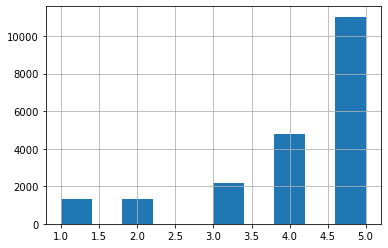

In [20]:
raw_data = pd.read_csv('yandex_marker_phone_reviews.csv')
# sum(button_data.rate < 4)
raw_data.rate.hist()
plt.show()

Убираем отзывы с серединными оценками (3 и 4). Положительными отзывами считаем отзывы с оценкой 5, отрицательными 1 и 2.

In [46]:
data = raw_data
data.review = [string.replace('\r', '') for string in data.review]
data = data[(data.rate != 3) & (data.rate != 4)]
data['label'] = [int(x) for x in data.rate == 5]
print('negative:', sum(data.label==0), '\npositive:',  sum(data.label==1))

negative: 2648 
positive: 11026


C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Осталось не так много отзывов. Уравняем классы.

## 2.1 UnderSampling

In [53]:
under_sampler = RandomUnderSampler()
X = data.drop(['label', 'rate'], axis=1)
X_under, y_under = under_sampler.fit_sample(X, data.label)
print('negative:', sum(y_under==0), '\npositive:',  sum(y_under==1))

negative: 2648 
positive: 2648


## 2.2 Baseline

In [59]:
pipeline = Pipeline([('vec', CountVectorizer()), ('cl', LogisticRegression(max_iter=500))])
acc = cross_val_score(pipeline, X_under.review, y_under, cv=5)
acc.mean(), 2 * acc.std()

(0.888785076701053, 0.02330473507970651)

## 2.3 Сравнение разных алгоритмов

ВНИМАНИЕ! Считает минут 15-20.

In [64]:
vectorizers = [
    ('Count simple', CountVectorizer()),
#     ('Count stop_words', CountVectorizer(stop_words='english')),
#     ('Count stop_words nltk', CountVectorizer(stop_words=stop_words)),
    ('Count ngramm 1, 2', CountVectorizer(ngram_range=(1, 2))),
    ('Count ngramm 1, 3', CountVectorizer(ngram_range=(1, 3))),
    ('Count min_df=10', CountVectorizer(min_df=10)),
    ('Count min_df=50', CountVectorizer(min_df=50)),
    ('TfIdf simple', TfidfVectorizer()),
#     ('TfIdf stop_words', TfidfVectorizer(stop_words='english')),
#     ('TfIdf stop_words nltk', TfidfVectorizer(stop_words=stop_words)),
    ('TfIdf ngramm 1, 2', TfidfVectorizer(ngram_range=(1, 2))),
    ('TfIdf ngramm 1, 3', TfidfVectorizer(ngram_range=(1, 3))),
    ('TfIdf min_df=10', TfidfVectorizer(min_df=10)),
    ('TfIdf min_df=50', TfidfVectorizer(min_df=50))
]
classifiers = [
    ('LogisticRegression', LogisticRegression(max_iter=500)),
    ('LinearSVC', LinearSVC(max_iter=500)),
    ('SGDClassifier', SGDClassifier(max_iter=500)),
    ('RidgeClassifier', RidgeClassifier(max_iter=500)),
    ('MultinomialNB', MultinomialNB()),
    ('RandomForestClassifier', RandomForestClassifier())
]

In [67]:
table = pd.DataFrame(np.zeros((len(classifiers), len(vectorizers))))
table.columns = [descr for descr, _ in vectorizers]
table['classifier'] = [descr for descr, _ in classifiers]

table_std = pd.DataFrame(np.zeros((len(classifiers), len(vectorizers))))
table_std.columns = [descr for descr, _ in vectorizers]
table_std['classifier'] = [descr for descr, _ in classifiers]

for descrip_vec, vectorizer in vectorizers:
    for i, (descrip_cl, classifier) in enumerate(classifiers):
        pipeline = Pipeline([('vec', vectorizer), ('cl', classifier)])
        acc = cross_val_score(pipeline, X_under.review, y_under, cv=5)
        table[descrip_vec][i] = acc.mean()
        table_std[descrip_vec][i] = acc.std()

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value i

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value i

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value i

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value i

C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value i

In [68]:
table

,Count simple,Count stop_words,"Count ngramm 1, 2","Count ngramm 1, 3",Count min_df=10,Count min_df=50,TfIdf simple,TfIdf stop_words,"TfIdf ngramm 1, 2","TfIdf ngramm 1, 3",TfIdf min_df=10,TfIdf min_df=50,classifier
0,0.888785,0.889351,0.897282,0.891428,0.884631,0.861593,0.896527,0.896527,0.899926,0.895395,0.897659,0.877264,LogisticRegression
1,0.873302,0.872924,0.888030,0.881987,0.866317,0.834215,0.904834,0.905401,0.912388,0.909934,0.895772,0.868202,LinearSVC
2,0.861593,0.875568,0.890107,0.886708,0.860841,0.831953,0.897093,0.896903,0.912954,0.911822,0.886896,0.866314,SGDClassifier
3,0.833650,0.833272,0.882552,0.882552,0.778325,0.835914,0.904646,0.904079,0.911255,0.907101,0.897282,0.868202,RidgeClassifier
4,0.886894,0.887083,0.909368,0.910123,0.886895,0.869146,0.888217,0.888028,0.910689,0.912011,0.886328,0.873676,MultinomialNB
5,0.866881,0.862350,0.867827,0.866125,0.863484,0.850829,0.867258,0.852342,0.865181,0.859706,0.852529,0.847809,RandomForestClassifier


In [69]:
table_std

,Count simple,Count stop_words,"Count ngramm 1, 2","Count ngramm 1, 3",Count min_df=10,Count min_df=50,TfIdf simple,TfIdf stop_words,"TfIdf ngramm 1, 2","TfIdf ngramm 1, 3",TfIdf min_df=10,TfIdf min_df=50,classifier
0,0.011652,0.011345,0.009288,0.013577,0.013084,0.012630,0.010081,0.010081,0.012442,0.012150,0.007928,0.010617,LogisticRegression
1,0.013307,0.013746,0.013255,0.009660,0.013525,0.009946,0.014174,0.013581,0.010132,0.012790,0.014001,0.015044,LinearSVC
2,0.018183,0.006382,0.014843,0.014568,0.014261,0.018435,0.012677,0.014585,0.011013,0.011266,0.013234,0.013405,SGDClassifier
3,0.008478,0.007694,0.006379,0.010539,0.015543,0.011405,0.012116,0.012457,0.010802,0.012664,0.009917,0.012895,RidgeClassifier
4,0.018964,0.019051,0.016741,0.013623,0.018104,0.013954,0.020647,0.020896,0.015247,0.015029,0.019657,0.012941,MultinomialNB
5,0.012920,0.016184,0.017518,0.017161,0.010081,0.010501,0.010395,0.008316,0.016544,0.010512,0.008640,0.008070,RandomForestClassifier


Лучше всего работает TfidfVectorizer(ngram_range=(1, 2)) с SGDClassifier.
## 2.4 Лучшая модель и предсказание

In [74]:
pipeline = Pipeline([('vec', TfidfVectorizer(ngram_range=(1, 2))), ('cl', SGDClassifier(max_iter=500))])

In [80]:
with open('test.csv', encoding='utf-8') as input_file:
    lines = input_file.readlines()
test = ' '.join(lines).replace('\n', '').replace('<review>', '').split('</review>')
test = test[:-1]

In [81]:
pipeline.fit(X_under.review, y_under)
prediction = pipeline.predict(test)
prediction

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [86]:
pred_dict = {0: 'neg', 1: 'pos'}
prediction_str = [pred_dict[i] for i in prediction]
prediction_str[:5]

['neg', 'pos', 'neg', 'neg', 'pos']

In [87]:
answer = pd.DataFrame({'Id': [x for x in range(len(prediction_str))], 'y': prediction_str})
answer.to_csv('submission.csv', index=False)

На тестовых данных результат получился 0.94%. Можно улучшить, если собрать больше обучающую выборку и/или попробовать другой спозоб векторизации (word2vec).

Тут можно потестировать:

In [109]:
your_review = 'Норм мобила'
[pred_dict[i] for i in pipeline.predict([your_review])]

['pos']

In [110]:
with open('model.pkl', 'wb') as output_file:
    pickle.dump(pipeline, output_file)